# Starter Notebook
This notebook contains the basic code to train a GeodesyNet on accelerations synthetically generated from a ground truth  mascon model.
At the end of the training a quick look at the resulting neural density field is also given.

On CPU the training will still work but be slow, in that case use less points for the numercial quadrature and smaller batches. If you have access to a GPU everything will go much faster. With an Nvidia RTX2080Ti GPU a full training will take approximately one hour.

In [1]:
# Import our module containing helper functions
import gravann

# Core imports
import numpy as np
import pickle as pk
import os
from collections import deque

# pytorch
from torch import nn
import torch

# plotting stuff
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib notebook

# Ensure that changes in imported module (gravann most importantly) are autoreloaded
%load_ext autoreload
%autoreload 2

# If possible enable CUDA
gravann.enableCUDA()
gravann.fixRandomSeeds()
device = os.environ["TORCH_DEVICE"]
print("Will use device ",device)

C:\Users\josch\miniconda3\envs\geodesynet\lib\site-packages\pyvista\themes.py:131: PyVistaDeprecationWarning: use "dark" instead of "night" theme
  warnings.warn('use "dark" instead of "night" theme', PyVistaDeprecationWarning)


Available devices  1
__pyTorch VERSION: 1.13.1
__CUDNN VERSION: 8500
__Number CUDA Devices: 1
Active CUDA Device: GPU 0
Setting default tensor type to Float32
Will use device  cuda:0


# Loading and visualizing the ground truth asteroid (a point cloud)

In [2]:
# one of "eros", "bennu", "itokawa", "chryumov-gerasimenko", "planetesimal", "torus", "bennu_nu", "itokawa_nu", "planetesimal_nu"
name_of_gt = "eros"

In [3]:
# We load the ground truth (a mascon model of some body)
with open("mascons/"+name_of_gt+".pk", "rb") as file:
    mascon_points, mascon_masses, mascon_name = pk.load(file)
    
mascon_points = torch.tensor(mascon_points)
mascon_masses = torch.tensor(mascon_masses)

# Print some information on the loaded ground truth 
# (non-dimensional units assumed. All mascon coordinates are thus in -1,1 and the mass is 1)
print("Name: ", mascon_name)
print("Number of mascons: ", len(mascon_points))
print("Total mass: ", sum(mascon_masses))

# Each mascon has a closest neighbour. The least close one is here computed (non dimensional units).
# Its a quantity that is of interest when checking mascon models coming from gravitationally stable aggregates.
print("Maximal minimal distance:",gravann.max_min_distance(mascon_points))

Name:  Eros
Number of mascons:  39554
Total mass:  tensor(1.0000, dtype=torch.float64)
Maximal minimal distance: 0.06402954459190369


<IPython.core.display.Javascript object>


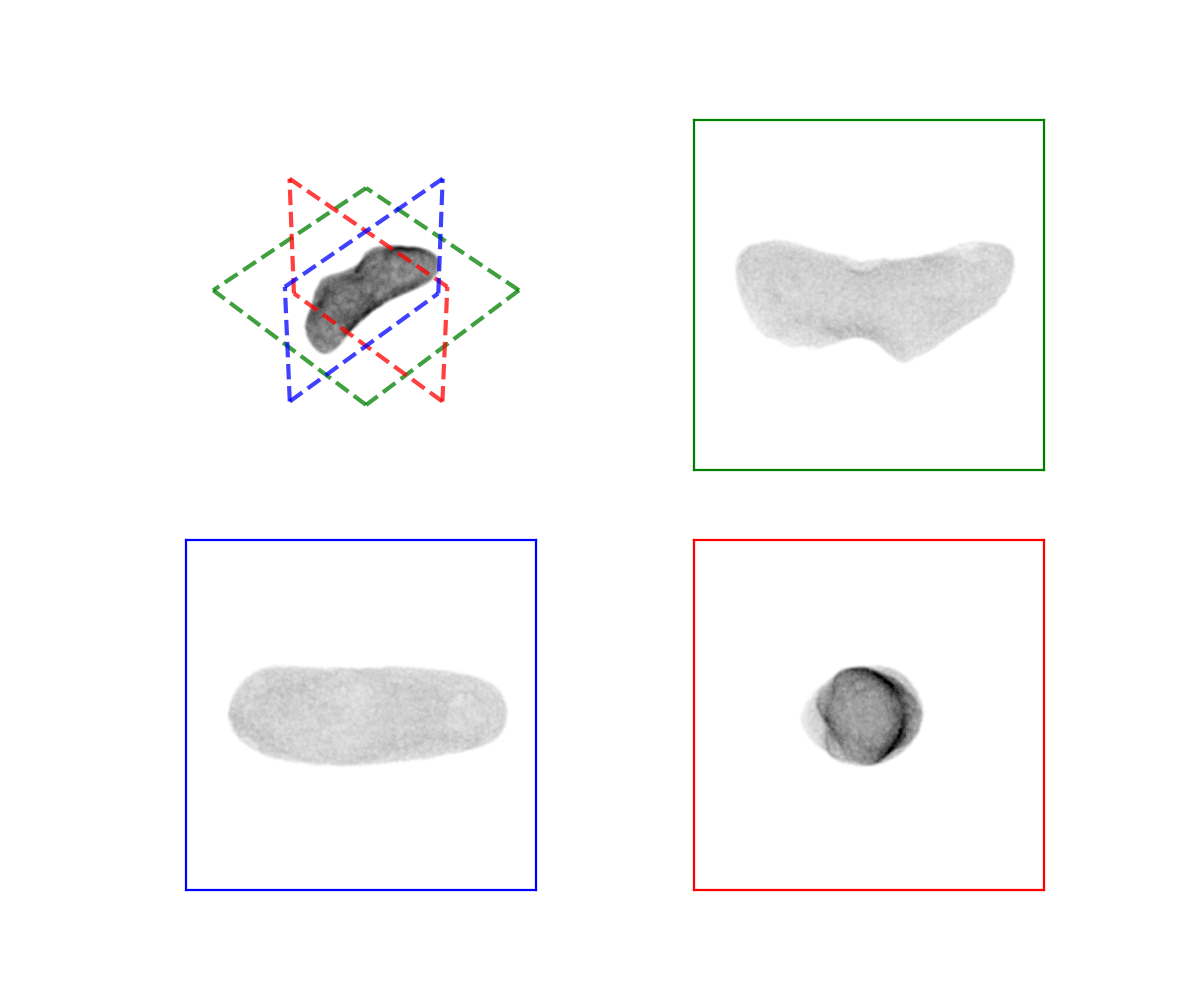

In [4]:
# Here we visualize the loaded ground truth
gravann.plot_mascon(mascon_points, mascon_masses,alpha=0.005)

# Representing the asteroid mass distribution via a neural network


## 1 - Defining the network architecture
We here use functions from our module as to not clutter the notebook, but the code is rather straight forward: a FFNN with some options.

In [5]:
# Encoding: direct encoding (i.e. feeding the network directly with the Cartesian coordinates in the unit hypercube)
# was found to work well in most cases. But more options are implemented in the module.
encoding = gravann.direct_encoding()

# The model is here a SIREN network (FFNN with sin non linearities and a final absolute value to predict the density)
model = gravann.init_network(encoding, n_neurons=100, model_type="siren", activation = gravann.AbsLayer())
#model = gravann.init_network(encoding, n_neurons=100, model_type="siren", activation = gravann.SquaredReLU())
#model = gravann.init_network(encoding, n_neurons=100, model_type="siren", activation = torch.nn.ReLU())


# When a new network is created we init empty training logs
loss_log = []
weighted_average_log = []
running_loss_log = []
n_inferences = []
# .. and we init a loss trend indicators
weighted_average = deque([], maxlen=20)

In [6]:
## ---------------------------------------------------------------------------------------
## IF YOU WANT TO LOAD AN ALREADY TRAINED NETWORK UNCOMMENT HERE.
## 300000 points used for the quadrature, 1000 for batches and trained for 20000 epochs
## If a model is preloaded skip to the later interpretation of results cells
## ---------------------------------------------------------------------------------------

#model.load_state_dict(torch.load("models/"+name_of_gt+".mdl"))

# Once a model is loaded the learned constant c (named kappa in the paper) is unknown 
# and must be relearned (ideally it should also be saved at the end of the training as it is a learned parameter)
c = gravann.compute_c_for_model(model, encoding, mascon_points, mascon_masses, use_acc = True)

C:\Users\josch\miniconda3\envs\geodesynet\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## 2 - Visualizing the initial neural density field
The network output is a mass density in the unit cube. Essentially a three dimensional function which we here plot via rejection sampling (for now this method is good enough)

Sampling points...: 10971it [00:01, 6180.07it/s]                                                                       


<IPython.core.display.Javascript object>


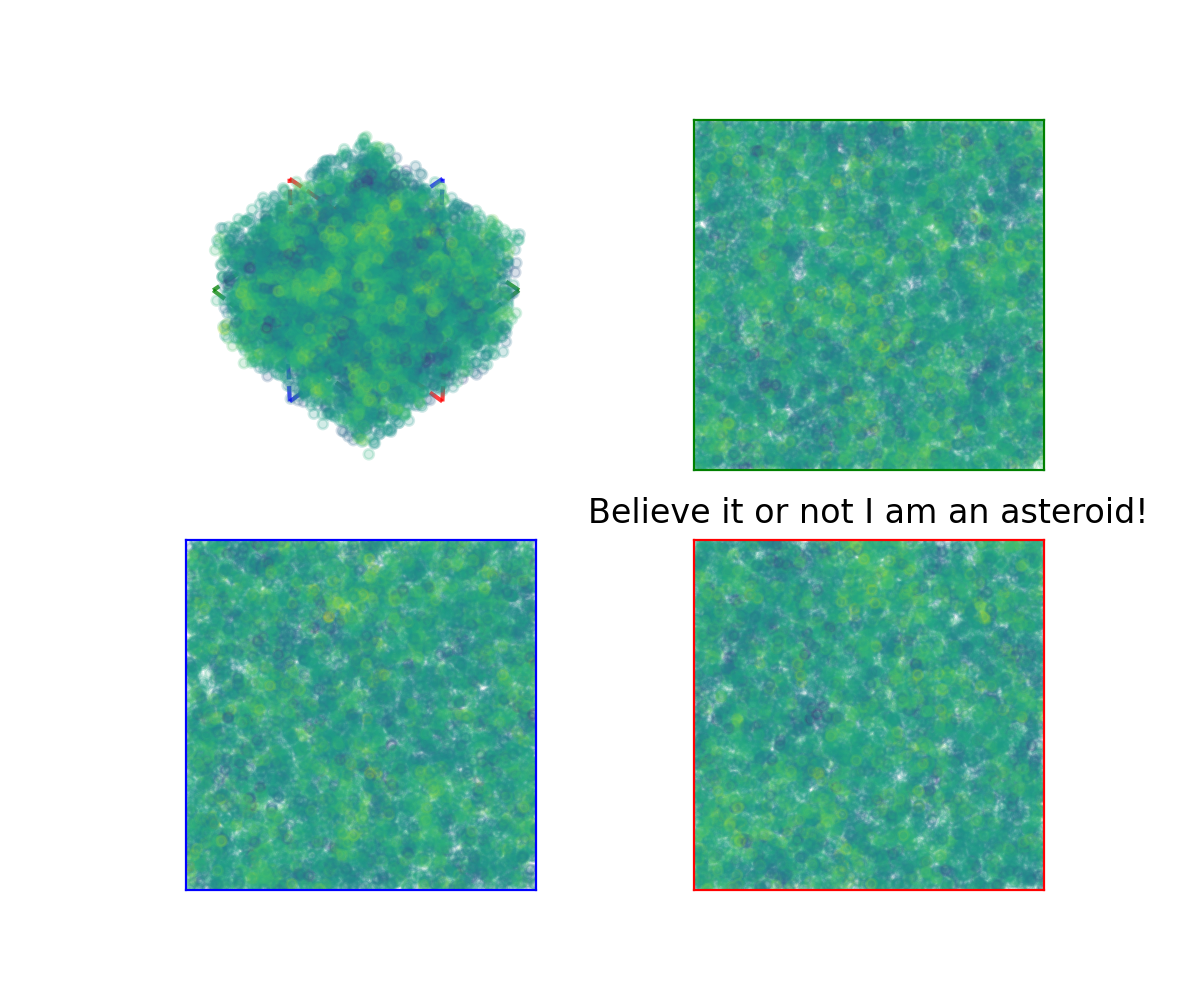

Text(0.5, 1.0, 'Believe it or not I am an asteroid!')

In [7]:
# The rejection plot will visualize the neural density field as a probability distribution function. 
# Colors represent the density magnitude (white being zero). 
# At the beginning, the whole hypercube is filled with some non vanishing density.
gravann.plot_model_rejection(model, encoding, views_2d=True, N=10000, progressbar=True, c=c)
plt.title("Believe it or not I am an asteroid!")

# Training of a geodesyNet

In [8]:
# EXPERIMENTAL SETUP ------------------------------------------------------------------------------------
# Number of points to be used to evaluate numerically the triple integral
# defining the acceleration. 
# Use <=30000 to for a quick training ... 300000 was used to produce most of the paper results
n_quadrature = 10000

# Dimension of the batch size, i.e. number of points
# where the ground truth is compared to the predicted acceleration
# at each training epoch.
# Use 100 for a quick training. 1000  was used to produce most of the paper results
batch_size = 100

# Loss. The normalized L1 loss (kMAE in the paper) was
# found to be one of the best performing choices.
# More are implemented in the module
loss_fn = gravann.normalized_L1_loss

# The numerical Integration method. 
# Trapezoidal integration is here set over a dataset containing acceleration values,
# (it is possible to also train on values of the gravity potential, results are similar)
mc_method = gravann.ACC_trap

# The sampling method to decide what points to consider in each batch.
# In this case we sample points unifromly in a sphere and reject those that are inside the asteroid
targets_point_sampler = gravann.get_target_point_sampler(batch_size, 
                                                         limit_shape_to_asteroid="3dmeshes/"+name_of_gt+"_lp.pk", 
                                                         method="spherical", 
                                                         bounds=[0,1])
# Here we set the optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.8, patience = 200, min_lr = 1e-6,verbose=True)

# And init the best results
best_loss = np.inf
best_model_state_dict = model.state_dict()

**Note: the cell below is explicitly typed for convenience, as this is a tutorial-ish after all, but the module gravann contains a function (train_on_batch) that does the same**

In [9]:
# TRAINING LOOP (normal training, no use of any prior shape information)------------------------
# This cell can be stopped and started again without loosing memory of the training nor its logs
torch.cuda.empty_cache()
# The main training loop
for i in range(1000):
    # Each ten epochs we resample the target points
    if (i % 10 == 0):
        target_points = targets_point_sampler()
        # We compute the labels whenever the target points are changed
        labels = gravann.ACC_L(target_points, mascon_points, mascon_masses)
    
    # We compute the values predicted by the neural density field
    predicted = mc_method(target_points, model, encoding, N=n_quadrature, noise=0.)
    
    # We learn the scaling constant (k in the paper)
    c = torch.sum(predicted*labels)/torch.sum(predicted*predicted)
    
    # We compute the loss (note that the contrastive loss needs a different shape for the labels)
    if loss_fn == gravann.contrastive_loss:
       loss = loss_fn(predicted, labels)
    else:
       loss = loss_fn(predicted.view(-1), labels.view(-1))
    
    # We store the model if it has the lowest fitness 
    # (this is to avoid losing good results during a run that goes wild)
    if loss < best_loss:
        best_model_state_dict = model.state_dict()
        best_loss = loss
        print('New Best: ', loss.item())
        # Uncomment to save the model during training (careful it overwrites the model folder)
        #torch.save(model.state_dict(), "models/"+name_of_gt+".mdl")
    
    # Update the loss trend indicators
    weighted_average.append(loss.item())
    
    # Update the logs
    weighted_average_log.append(np.mean(weighted_average))
    loss_log.append(loss.item())
    n_inferences.append((n_quadrature*batch_size) // 1000000) #counted in millions
    
    # Print every i iterations
    if i % 25 == 0:
        wa_out = np.mean(weighted_average)
        print(f"It={i}\t loss={loss.item():.3e}\t  weighted_average={wa_out:.3e}\t  c={c:.3e}")
        
    # Zeroes the gradient (necessary because of things)
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()
    
    # Perform a step in LR scheduler to update LR
    scheduler.step(loss.item())

New Best:  0.4873465597629547
It=0	 loss=4.873e-01	  weighted_average=4.873e-01	  c=5.826e+00
New Best:  0.4461017847061157
New Best:  0.41470882296562195
New Best:  0.38114163279533386
New Best:  0.36146843433380127
New Best:  0.3495315611362457
New Best:  0.3035711348056793
New Best:  0.2397478222846985
New Best:  0.19115062057971954
New Best:  0.18034665286540985
New Best:  0.15778034925460815
New Best:  0.15307720005512238
New Best:  0.11712294816970825
It=25	 loss=1.227e-01	  weighted_average=2.597e-01	  c=7.183e+00
New Best:  0.10599211603403091
New Best:  0.10186272114515305
New Best:  0.07394008338451385
New Best:  0.06843221932649612
New Best:  0.0635286197066307
New Best:  0.05620458722114563
New Best:  0.046980179846286774
New Best:  0.04329666495323181
New Best:  0.042705073952674866
New Best:  0.041974496096372604
New Best:  0.040669023990631104
New Best:  0.03995479643344879
New Best:  0.03211209923028946
New Best:  0.02903766743838787
It=50	 loss=4.365e-02	  weighted_ave

In [10]:
# Here we restore the learned parameters of the best model of the run
for layer in model.state_dict():
    model.state_dict()[layer] = best_model_state_dict[layer]

# 3 - Interpretation of the neural density field learned

<IPython.core.display.Javascript object>


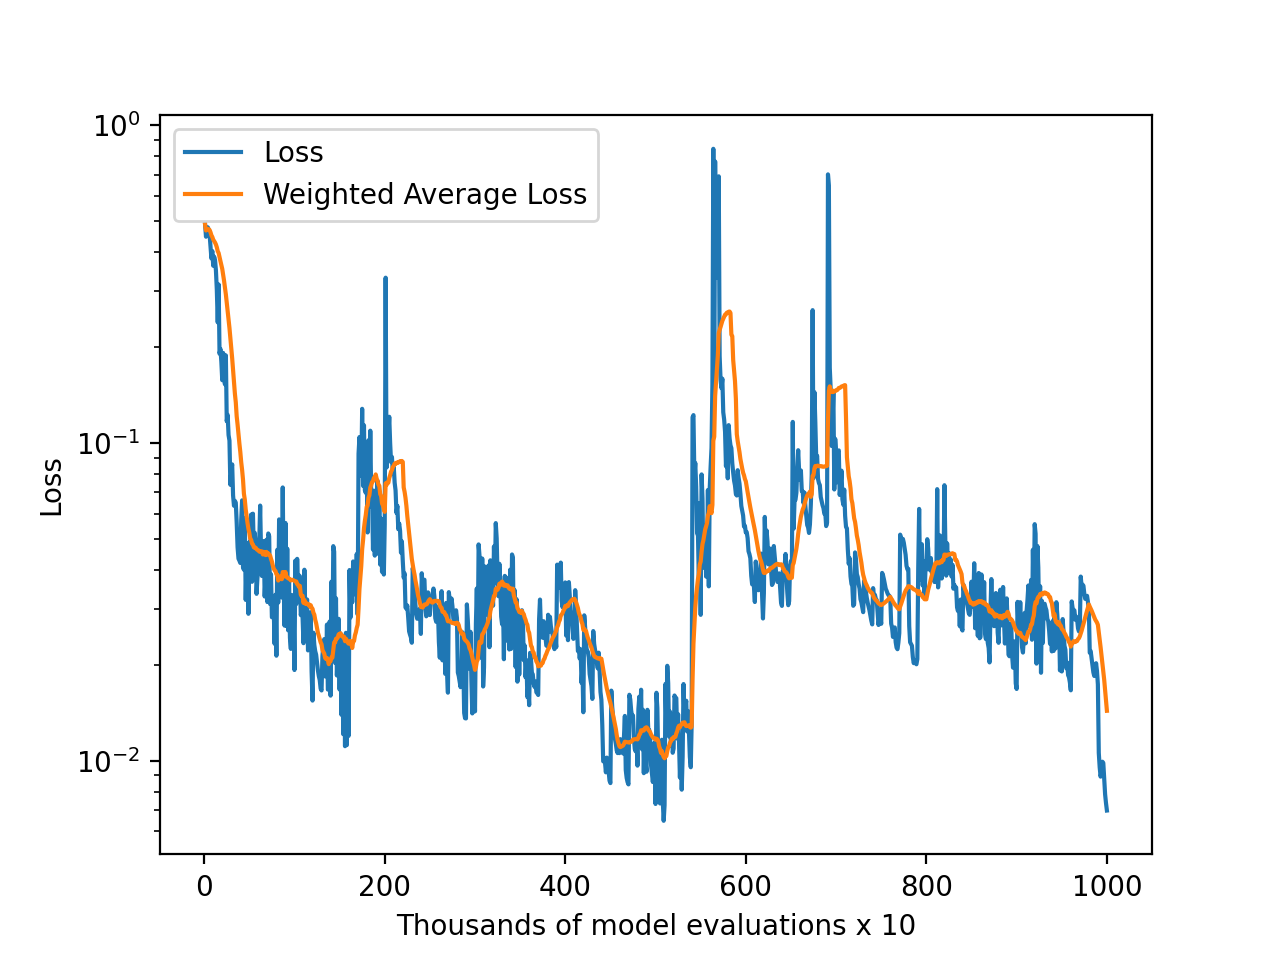

In [11]:
# First lets have a look at the training loss history
plt.figure()
abscissa = np.cumsum(n_inferences)
plt.semilogy(abscissa,  loss_log)
plt.semilogy(abscissa,  weighted_average_log)
plt.xlabel("Thousands of model evaluations x 10")
plt.ylabel("Loss")
plt.legend(["Loss","Weighted Average Loss"])

Sampling points...: 1606it [00:01, 1429.64it/s]                                                                        


<IPython.core.display.Javascript object>


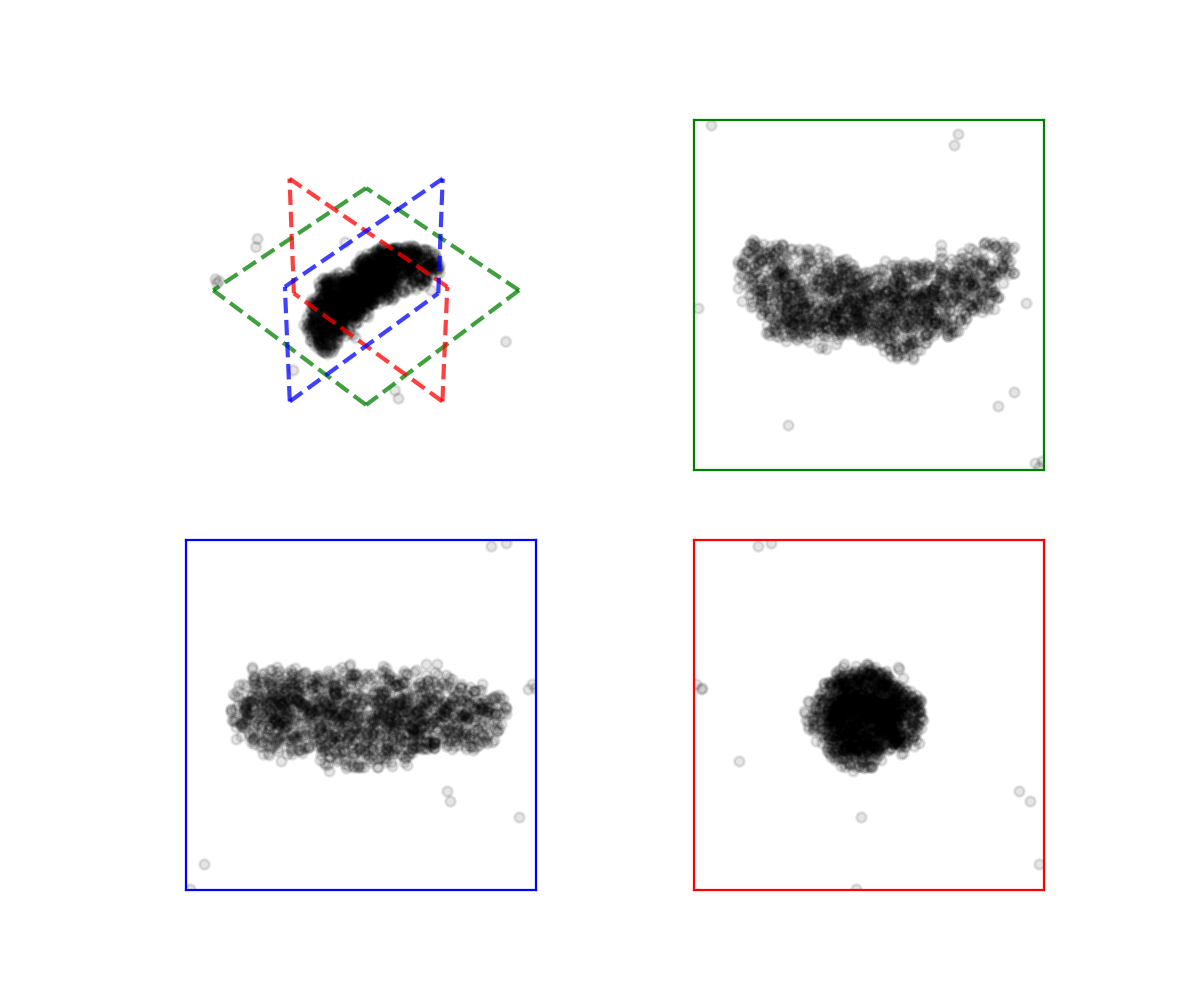

<IPython.core.display.Javascript object>


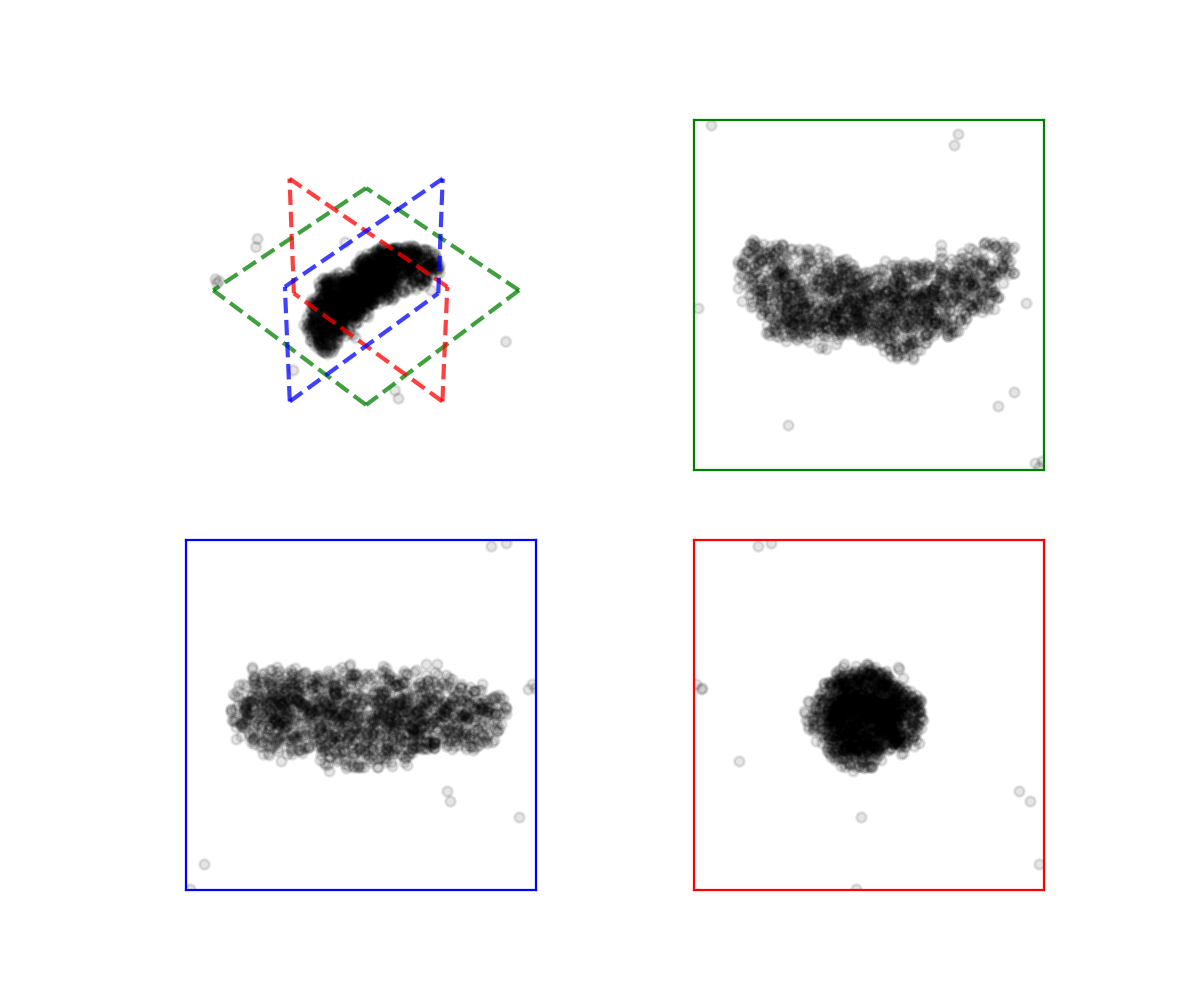

In [12]:
# Lets have a look at the neural density field.
# First with a rejection plot
gravann.plot_model_rejection(model, encoding, views_2d=True, bw=True, N=1500, alpha=0.1, s=50, c=c, crop_p=0.1, progressbar=True)

Sampling points...: 5049it [00:02, 1708.73it/s]                                                                        


<IPython.core.display.Javascript object>


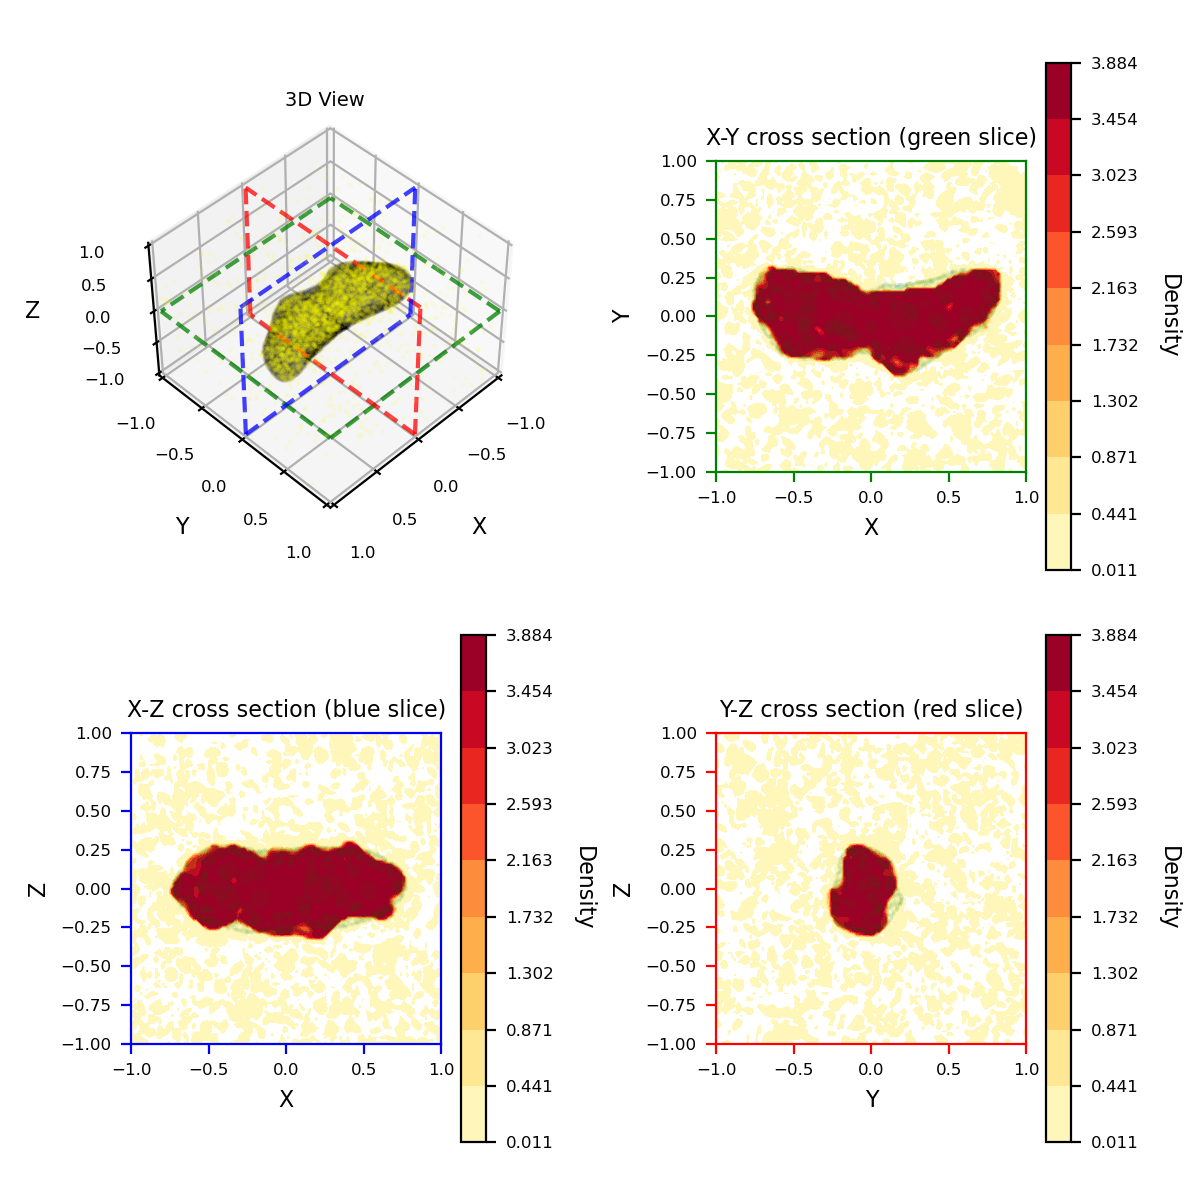

<Axes3DSubplot: title={'center': '3D View'}, xlabel='X', ylabel='Y', zlabel='Z'>

In [13]:
# Then overlaying a heatmap to the mascons 
gravann.plot_model_vs_mascon_contours(model, encoding, mascon_points, mascon_masses,c=c, progressbar = True, N=5000, heatmap=True)

In [14]:
# Computes the Validation table with rel and abs errors on the predicted acceleration (w.r.t. ground truth) 
# at low, med, high altitudes (see paper). is requires sampling quite a lot, so it takes time 
# IMPORTANT: the N_integration should be equal to n_quadrature used for training. Else results degrade.
results_geodesyNet = gravann.validation(model, encoding, mascon_points, mascon_masses, 
                use_acc=True, 
                asteroid_pk_path="3dmeshes/"+name_of_gt+".pk", 
                N=10000, 
                N_integration=300000,  # This needs to be the same as the number used during training, else precision will be lost
                batch_size=100, 
                progressbar=True)

Computing validation...:  60%|█████████████████████████████▏                   | 44300/74244 [00:42<00:27, 1085.44it/s]

Discarding 4193 of 14744 points in altitude sampler which did not meet requested altitude.


Computing validation...:  73%|████████████████████████████████████▋             | 54400/74244 [01:14<00:36, 540.89it/s]

Discarding 7421 of 14744 points in altitude sampler which did not meet requested altitude.


Computing validation...:  87%|███████████████████████████████████████████▎      | 64400/74244 [01:42<00:17, 547.46it/s]

Discarding 11243 of 14744 points in altitude sampler which did not meet requested altitude.


Computing validation...: 74400it [02:06, 586.39it/s]                                                                   


In [15]:
results_geodesyNet

,Altitude,Normalized L1 Loss,Normalized Relative Component Loss,RMSE,relRMSE
0,Low Altitude,0.201274,0.132210,1.032987,0.216546
1,High Altitude,0.106471,0.082096,0.536388,0.126512
2,Altitude_0,0.116596,0.088121,0.421516,0.105336
3,Altitude_1,0.060425,0.055509,0.215303,0.065449
4,Altitude_2,0.020205,0.030561,0.082045,0.039322


In [16]:
# Select the units according to the model used (lazyness... a dict would do better)
factor_planetesimal = 9.982e12 * 6.67430e-11 / 3126.6064453124995**2
factor_itokawa = 3.51e10 * 6.67430e-11 / 350.438691675663**2
factor_eros = 6.687e15 * 6.67430e-11 / 20413.864850997925**2
factor_bennu = (7.329e10   * 6.67430e-11  / 352.1486930549145**2)
factor_67p = 9.982e12 * 6.67430e-11 / 3126.6064453124995**2
factor = factor_eros

In [17]:
absolute = results_geodesyNet["Normalized L1 Loss"] * factor
relative = results_geodesyNet["Normalized Relative Component Loss"] 

In [18]:
# Prints the line for the table 1 in the paper
print(f"{absolute[2]:.2e} & {absolute[3]:.2e} & {absolute[4]:.2e} & {relative[2]*100:.2f} & {relative[3]*100:.2f} & {relative[4]*100:.3f}")

1.25e-04 & 6.47e-05 & 2.16e-05 & 8.81 & 5.55 & 3.056


Sampling points at altitude
Discarding 7421 of 14744 points in altitude sampler which did not meet requested altitude.
Got  5000  points.
Splitting in left / right hemisphere
Left:  2398  points.
Right:  2602  points.


<IPython.core.display.Javascript object>


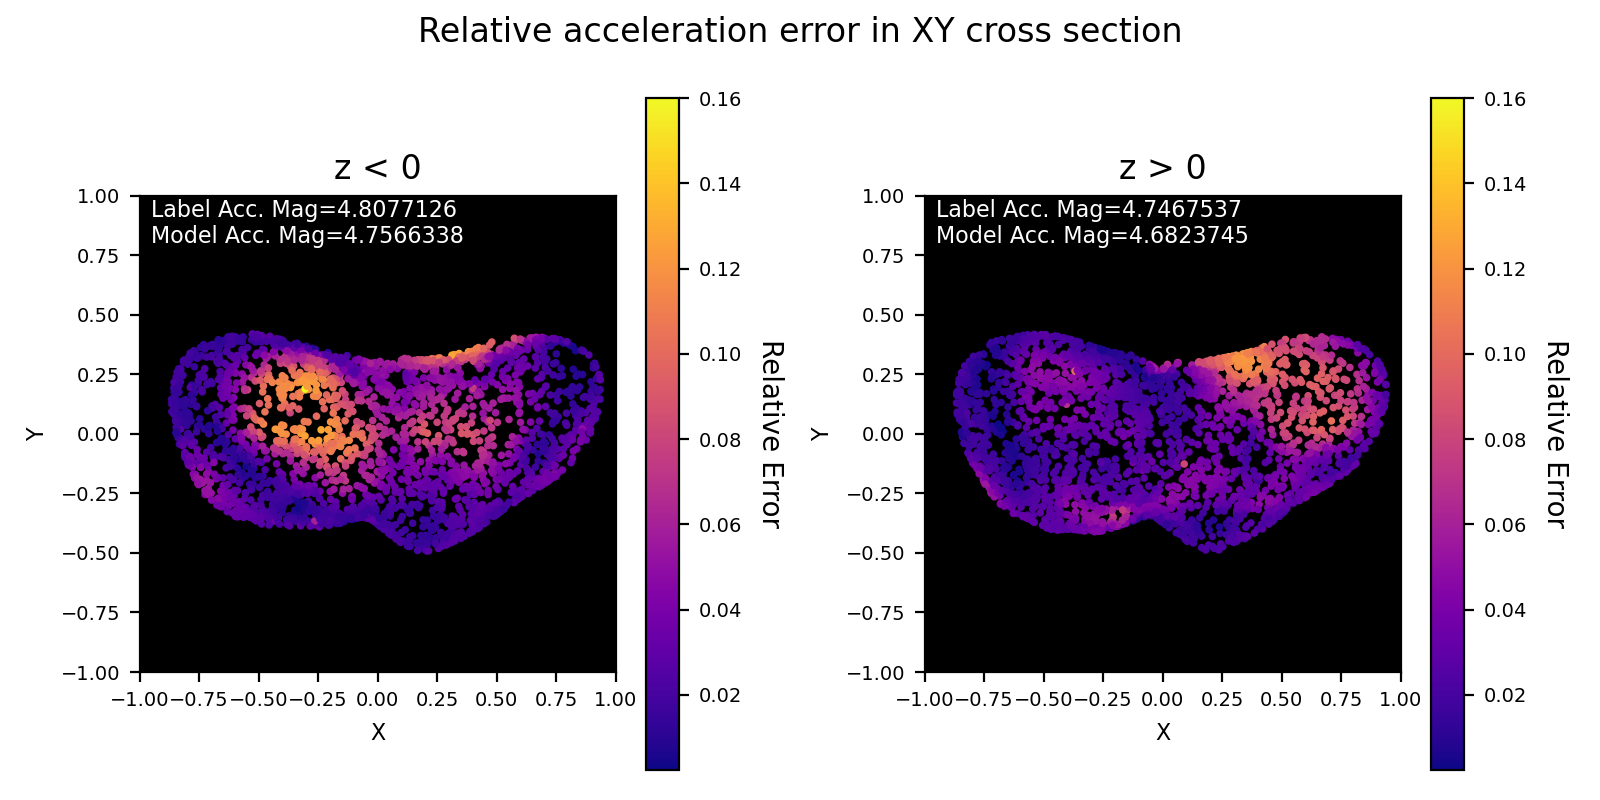

(<AxesSubplot: title={'center': 'z > 0'}, xlabel='X', ylabel='Y'>,
 tensor([[ 0.4072, -1.5169, -3.0449],
         [ 1.6336, -1.7090, -1.2609],
         [ 1.0685,  2.0838, -2.4910],
         ...,
         [-0.3373,  1.4628, -3.1644],
         [-1.3406,  1.9957, -2.5744],
         [-0.9642, -0.1858, -3.1264]]))

In [19]:
# Shows how the relative error is distribued along the asteroid surface (at some altitude) 
gravann.plot_model_mascon_acceleration("3dmeshes/"+name_of_gt+".pk", model, encoding, mascon_points, mascon_masses, plane="XY", c=c, N=5000, logscale=False, altitude=0.1)

<IPython.core.display.Javascript object>


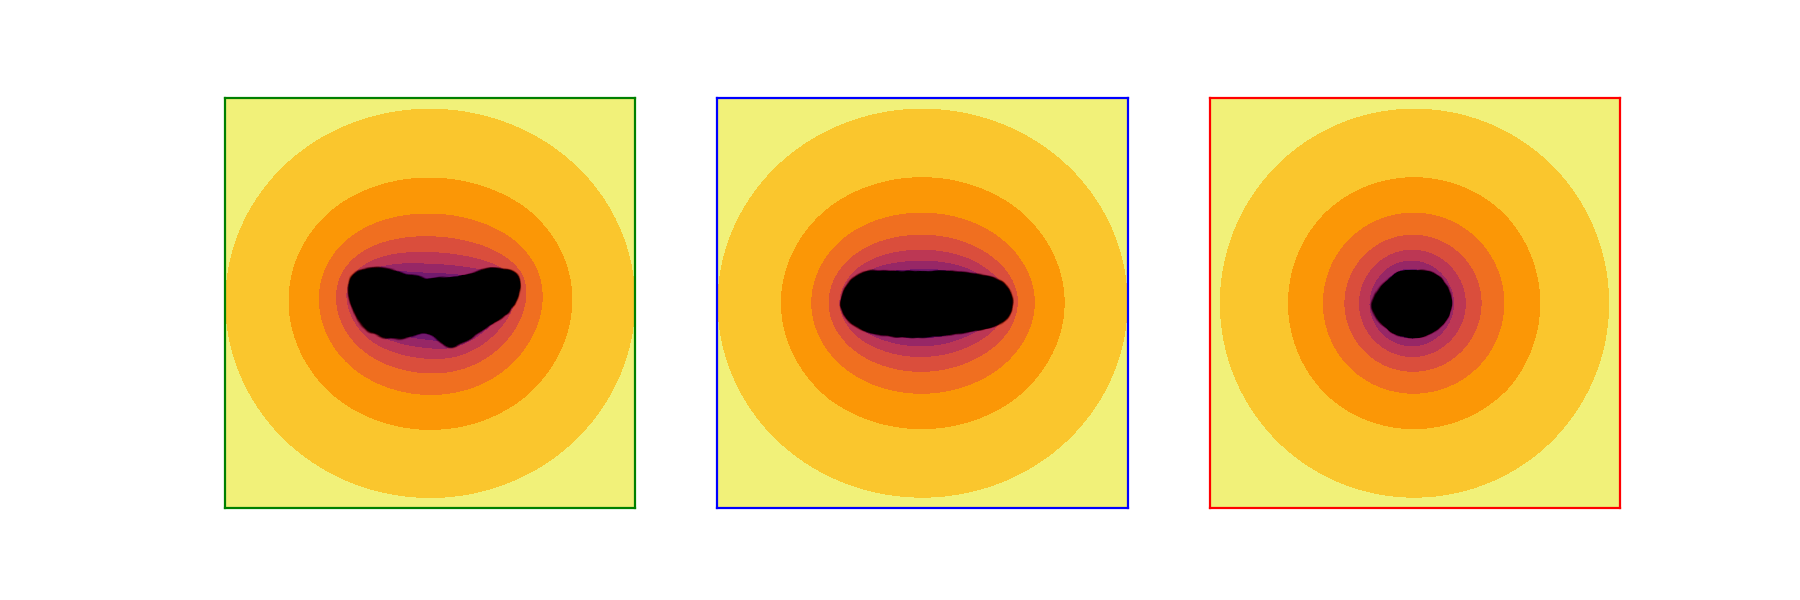

<AxesSubplot: >

In [20]:
# Shows the Contour plot of the gravity potential generated by the neural density field.
gravann.plot_potential_contours(model, encoding, mascon_points)

#### Saving the model

In [21]:
# Uncomment to save the model
torch.save(model.state_dict(), "models/"+name_of_gt+"_mascon_first.mdl")

In [22]:
y = torch.ones(1000,1)*0.
z = torch.ones(1000,1)*0.
x = torch.linspace(-1,1,1000).view(-1,1)
points = torch.concat((x,y,z), dim=1)

<IPython.core.display.Javascript object>


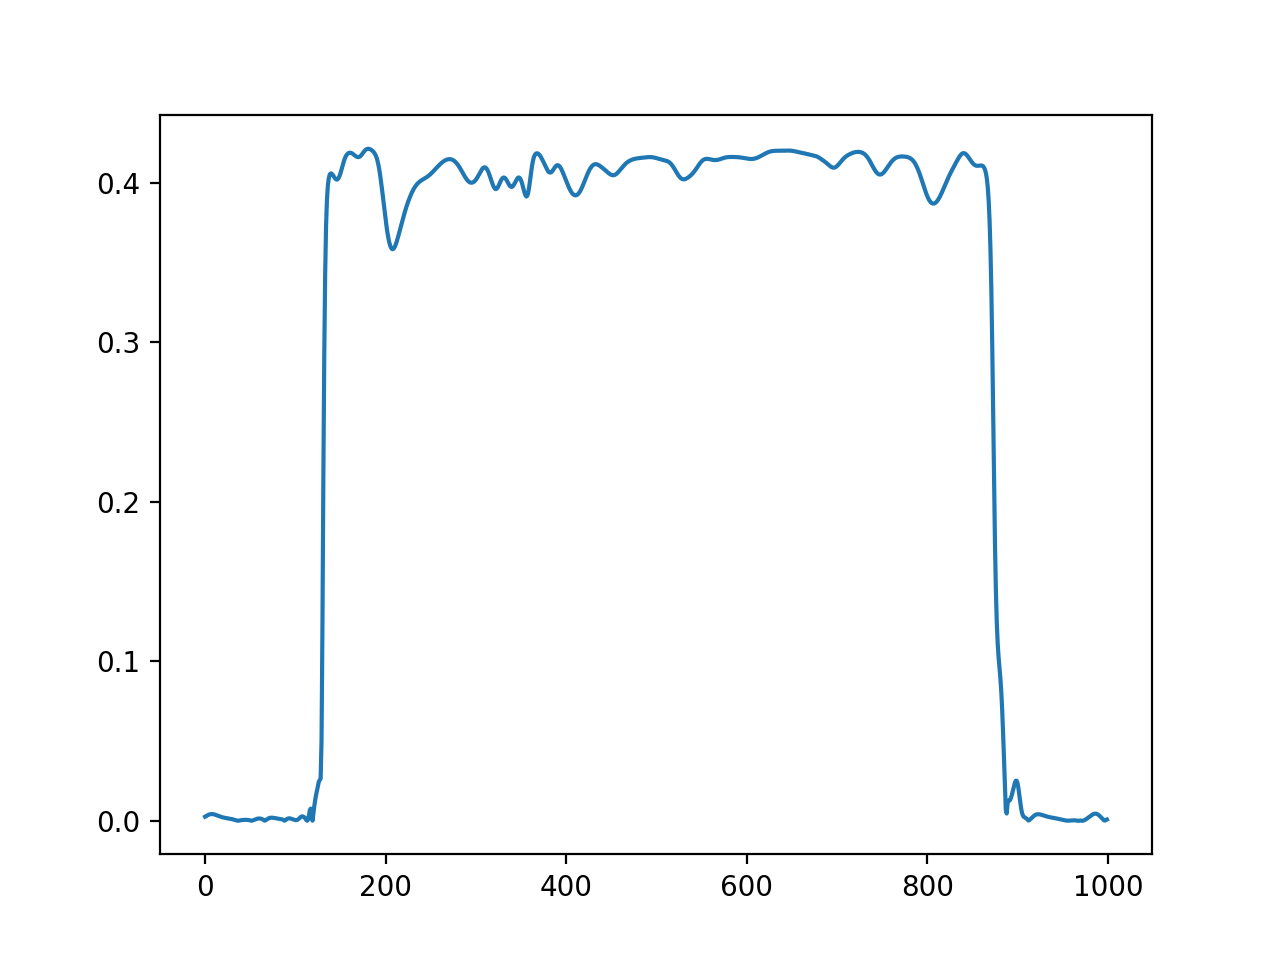

In [23]:
plt.figure()
plt.plot(model(points).detach().cpu().numpy())